<a href="https://colab.research.google.com/github/jangvu/Project_by_me/blob/main/sematic_segmentation_isbi_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
!ls "/content/drive/My Drive/Data"

101_ObjectCategories.tar.gz  candidate_test	NEU-DET.zip
Annotations.tar		     isbi-datasets.zip	NFLX.csv


In [8]:
!unzip -q "/content/drive/My Drive/Data/isbi-datasets.zip"


In [70]:
import os
IMAGES_PATH = "/content/isbi-datasets-master/data/images"
LABELS_PATH = "/content/isbi-datasets-master/data/labels"

IMAGES_DIR = os.listdir(IMAGES_PATH)
LABELS_DIR = os.listdir(LABELS_PATH)

print(len(IMAGES_DIR))
print(len(LABELS_DIR))

30
30


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

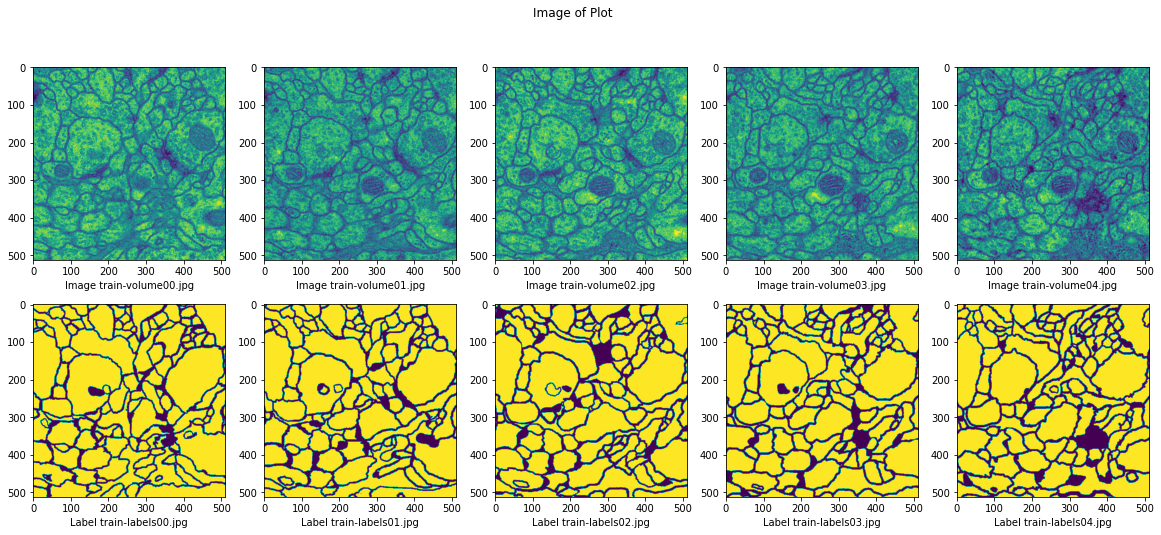

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

img_5_paths = sorted(IMAGES_DIR)[:5]
label_5_paths = sorted(LABELS_DIR)[:5]

# Khởi tạo subplot với 1 dòng 5 cột.
fg, ax = plt.subplots(2, 5, figsize=(20, 8))
fg.suptitle('Image of Plot')

for i, path in enumerate(img_5_paths):
  image = plt.imread(IMAGES_PATH +'/' +path)
  ax[0, i].imshow(image)
  ax[0, i].set_xlabel('Image ' + path.split('/')[-1])

for i, path in enumerate(label_5_paths):
  label = plt.imread(LABELS_PATH + '/' + path)
  ax[1, i].imshow(label)
  ax[1, i].set_xlabel('Label ' + path.split('/')[-1])

# **Pre-Processing Data**

In [139]:
INPUT_SHAPE = 572
OUTPUT_SHAPE = 386
data_image = []
labels_image = []
images_arr = []
labels_arr = []
for image in IMAGES_DIR:
    images_arr.append(IMAGES_PATH + "/" + image)
for label in LABELS_DIR:
    labels_arr.append(LABELS_PATH + "/" + label)

for img in images_arr:
  image = load_img(img, target_size=(new_size,new_size))
  data_image.append(img_to_array(image))

for label in labels_arr:
  label = load_img(label, target_size=(new_size,new_size))
  labels_image.append(img_to_array(label))


In [140]:
from sklearn.model_selection import train_test_split

## **Data Augmentation**

In [141]:
 def data_generation(all_image, all_label,input_dim,zoom_range = [0.5, 1], rotation =True,brightness_range= [0.8, 1]):
        image_data_after_aug = []
        label_data_after_aug = []
        # Khởi tạo dữ liệu
        for i in range(len(all_image)):
            # Đọc file từ folder name
            img = cv2.imread(all_image[i])
            label = cv2.imread(all_label[i])
            img = cv2.resize(img, input_dim)
            label = cv2.resize(label, input_dim)

            if zoom_range:
              zoom_scale = 1/np.random.uniform(zoom_range[0], zoom_range[1])
              (h, w, c) = img.shape
              img = cv2.resize(img, (int(h*zoom_scale), int(w*zoom_scale)), interpolation = cv2.INTER_LINEAR)
              label = cv2.resize(label, (int(h*zoom_scale), int(w*zoom_scale)), interpolation = cv2.INTER_LINEAR)
              label = label/255
              label[label > 0.5] = 1
              label[label < 0.5] = 0
              (h_rz, w_rz, c) = img.shape
              start_w = np.random.randint(0, w_rz-w) if (w_rz-w) > 0 else 0
              start_h = np.random.randint(0, h_rz-h) if (h_rz-h) > 0 else 0
              # print(start_w, start_h)
              img_zoom = img[start_h:(start_h+h), start_w:(start_w+w), :].copy()
              label_zoom = label[start_h:(start_h+h), start_w:(start_w+w), :].copy()
              image_data_after_aug.append(img_zoom)
              label_data_after_aug.append(label_zoom)
            
            if rotation:
              (h, w, c) = img.shape
              angle = np.random.uniform(rotation, rotation)
              RotMat = cv2.getRotationMatrix2D(center = (w, h), angle=angle, scale=1)
              img_rot = cv2.warpAffine(img, RotMat, (w, h))
              label_rot = cv2.warpAffine(label, RotMat, (w, h))
              image_data_after_aug.append(img_rot)
              label_data_after_aug.append(label_rot)

            if brightness_range:
              scale_bright = np.random.uniform(brightness_range[0], brightness_range[1])
              img_bri = img*scale_bright
              image_data_after_aug.append(img_bri)
              label_data_after_aug.append(label)
        return image_data_after_aug, label_data_after_aug


In [143]:
image_data_after_aug, label_data_after_aug = data_generation(images_arr,labels_arr, input_dim=(INPUT_SHAPE,INPUT_SHAPE))
print(len(image_data_after_aug))
print(len(label_data_after_aug))

90
90


## **Reshape Data**

In [144]:
X = []
y = []

for image in image_data_after_aug:
    image_resize = cv2.resize(image, (INPUT_SHAPE, INPUT_SHAPE), cv2.INTER_LINEAR)
    X.append(image_resize)
X = np.stack(X)

for label in label_data_after_aug:
    label_gray = np.mean(label, axis=2)
    label_resize = cv2.resize(label_gray, (OUTPUT_SHAPE, OUTPUT_SHAPE), cv2.INTER_LINEAR)
    label_binary = np.array(label_resize == 255).astype('float32')
    label_binary = label_binary[..., np.newaxis]
    y.append(label_binary)
y = np.stack(y)
print(X.shape)
print(y.shape)

(90, 572, 572, 3)
(90, 386, 386, 1)


3


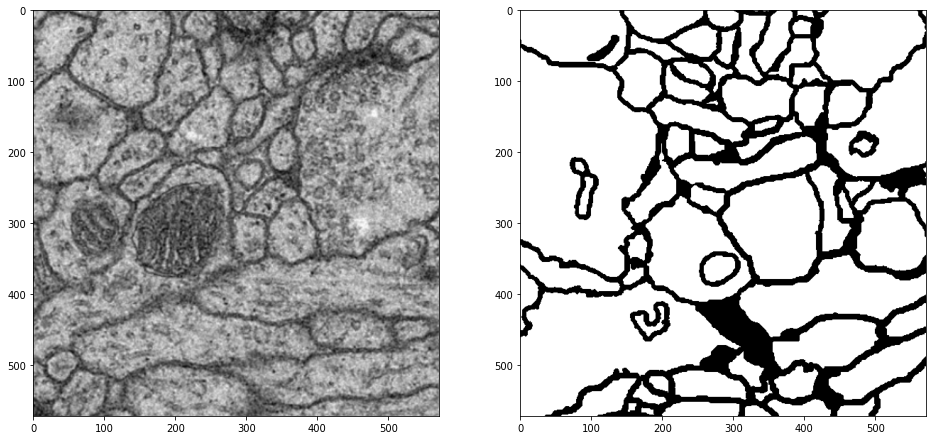

In [145]:
rand_ind = np.random.randint(8)
print(rand_ind)
plt.subplots(figsize=(16, 8))
plt.subplot(121)
plt.imshow(image_data_after_aug[rand_ind]/255)
plt.subplot(122)
plt.imshow(label_data_after_aug[rand_ind])

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
print(X_train.shape, y_train.shape)

(72, 572, 572, 3) (72, 386, 386, 1)


# **Creating Unet Model**

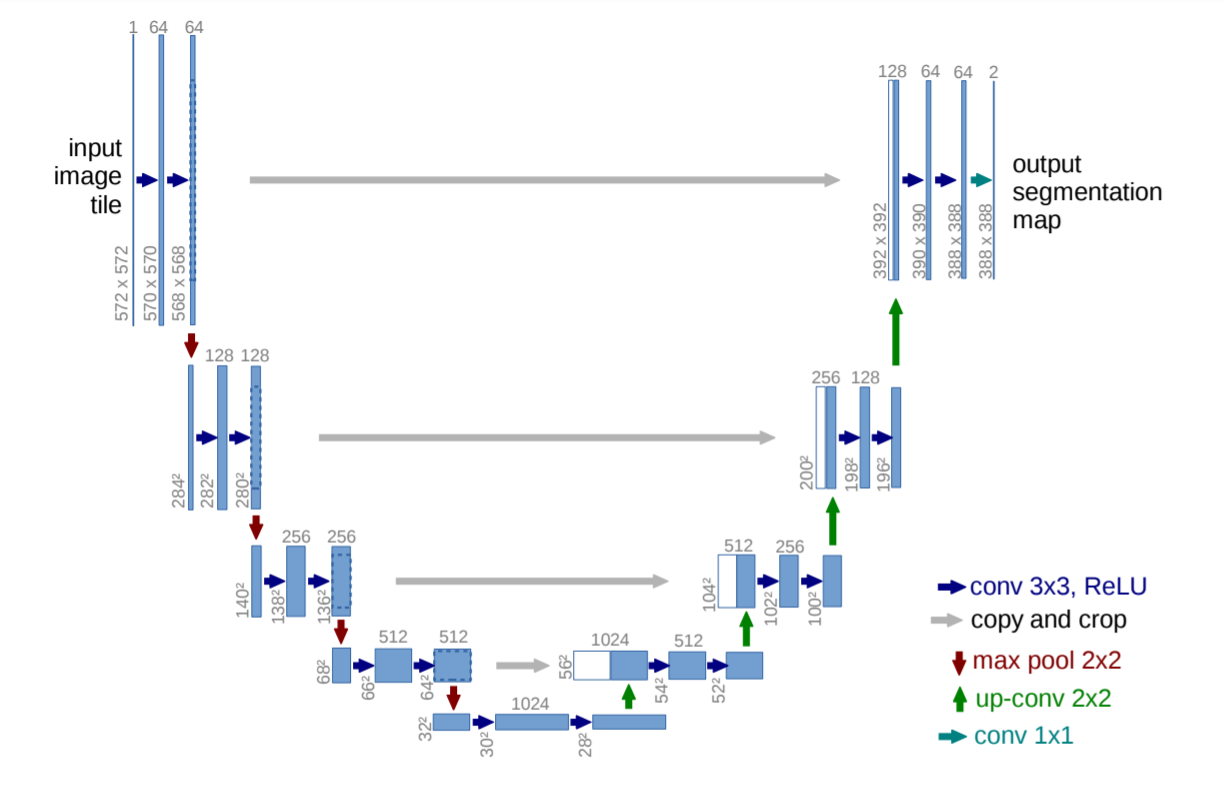

In [138]:
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D,UpSampling2D, concatenate, Dropout,Lambda, Conv2DTranspose, Add
from tensorflow.keras import Model

def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [129]:
model = unet()

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(X_train, y_train,validation_split = 0.2,epochs = 100,callbacks = [early_stopping])


In [133]:
import tensorflow as tf



def _downsample_cnn_block(block_input, channel, is_first = False):
  if is_first:  
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(block_input)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(conv1)
    return [block_input, conv1, conv2]
  else:
    maxpool = tf.keras.layers.MaxPool2D(pool_size=2)(block_input)
    conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(maxpool)
    conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(conv1)
    return [maxpool, conv1, conv2]

def _upsample_cnn_block(block_input, block_counterpart, channel, is_last = False):  
  # Upsampling block
  uppool1 = tf.keras.layers.Convolution2DTranspose(channel, kernel_size=2, strides=2)(block_input)
  # Crop block counterpart
  shape_input = uppool1.shape[2]
  shape_counterpart = block_counterpart.shape[2]
  crop_size = int((shape_counterpart-shape_input)/2)
  block_counterpart_crop = tf.keras.layers.Cropping2D(cropping=((crop_size, crop_size), (crop_size, crop_size)))(block_counterpart)
  concat = tf.keras.layers.Concatenate(axis=-1)([block_counterpart_crop, uppool1])
  conv1 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(concat)
  conv2 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, strides=1)(conv1)
  if is_last:
    conv3 = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, activation='sigmoid')(conv2)
    return [concat, conv1, conv2, conv3]
  return [uppool1, concat, conv1, conv2]

In [147]:
from tensorflow.keras.optimizers import Adam

def _create_model():
  ds_block1 = _downsample_cnn_block(tf.keras.layers.Input(shape=(INPUT_SHAPE, INPUT_SHAPE, 3)), channel=64, is_first = True)
  ds_block2 = _downsample_cnn_block(ds_block1[-1], channel=128)
  ds_block3 = _downsample_cnn_block(ds_block2[-1], channel=256)
  ds_block4 = _downsample_cnn_block(ds_block3[-1], channel=512)
  ds_block5 = _downsample_cnn_block(ds_block4[-1], channel=1024)
  us_block4 = _upsample_cnn_block(ds_block5[-1], ds_block4[-1], channel=512)
  us_block3 = _upsample_cnn_block(us_block4[-1], ds_block3[-1], channel=256)
  us_block2 = _upsample_cnn_block(us_block3[-1], ds_block2[-1], channel=128)
  us_block1 = _upsample_cnn_block(us_block2[-1], ds_block1[-1], channel=64, is_last = True)
  model = tf.keras.models.Model(inputs = ds_block1[0], outputs = us_block1[-1])
  model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics='accuracy')
  return model

model = _create_model()

In [150]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

history=model.fit(X_train, y_train,batch_size = 8,epochs = 5,callbacks = (EarlyStopping(patience=2, restore_best_weights=True))
  # callbacks = [lr_callback]
)


Epoch 1/5
9/9 [==============================] - 12s 1s/step - loss: 9.2978e-16 - accuracy: 1.0000
Epoch 2/5
9/9 [==============================] - 12s 1s/step - loss: 9.2978e-16 - accuracy: 1.0000
Epoch 3/5
9/9 [==============================] - 12s 1s/step - loss: 9.2980e-16 - accuracy: 1.0000
Epoch 4/5
9/9 [==============================] - 12s 1s/step - loss: 9.2979e-16 - accuracy: 1.0000
Epoch 5/5
9/9 [==============================] - 12s 1s/step - loss: 9.2981e-16 - accuracy: 1.0000


In [151]:
y_pred = model.predict(X_test)

In [154]:
imgray = y_pred[0]

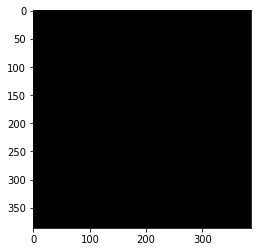

In [155]:
img2 = cv2.merge((imgray,imgray,imgray))
plt.imshow(img2)
plt.show()